## Getting the data ready 

In [1]:
# installing the needed libraries 
!pip install transformers seqeval datasets wandb git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite optuna translate

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-yydhi69z
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-yydhi69z
     |████████████████████████████████| 2.8 MB 4.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 264 kB 45.8 MB/s 
     |████████████████████████████████| 1.7 MB 32.6 MB/s 
     |████████████████████████████████| 302 kB 30.4 MB/s 
     |████████████████████████████████| 895 kB 38.2 MB/s 
     |████████████████████████████████| 3.3 MB 47.9 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 636 kB 33.3 MB/s 
     |████████████████████████████████| 119 kB 49.5 MB/s 
     |████████████████████████████████| 243 kB 55.2 MB/s 
     |████████████████████████████████| 133 kB 49.1 MB/s 
     |████████████████████████████████| 170 kB 44.9 MB/s 
     |████████████████████████████████| 97 kB 6

In [2]:
# Assign tensorflow to version 1 
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
#Import drive to connect to my google drive
from google.colab import drive 

# Essential libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from functools import reduce
from operator import add
from ast import literal_eval
import codecs
from tqdm import tqdm

# Hyperparamter tunning library
import optuna

from translate import Translator

# Import libraries for creating neural network
from keras import Model, Input
from keras.layers import GRU, Embedding, Dense,Masking
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.metrics import crf_accuracy
from keras_contrib.losses import crf_loss
from keras.optimizers import Adam
from keras.backend import clear_session
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

import torch

# Libraries for splitting data , and evalute the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

# Import huggingface library to get used transformer and its tokenizer
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from datasets import load_metric

# Imported for nicely display the output of the model
from spacy import displacy

# Imported tools for data preprocessing
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import wordpunct_tokenize
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Open the files on my drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Reading traning and testing data
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [6]:
# Change the type of annotations from string to array
train.annotations = train.annotations.map(literal_eval)
test.annotations = test.annotations.map(literal_eval)

In [7]:
# display the first 5 rows in traning data
train.head()

,text,annotations
0,طيب لو عايز احول من باقة الانترنت بتاعتى لرقم ...,"[{'start': 46, 'end': 57, 'entity': 'phonenumb..."
1,ممكن أعرف متبقيلي ميجابايتس قد ايه؟,"[{'start': 18, 'end': 27, 'entity': 'unit'}]"
2,شو سعر دقيقة التجوال فى السعودية,"[{'start': 24, 'end': 32, 'entity': 'country'}..."
3,عاوز اضيف دقايق تجوال للرقم ده 01100000011,"[{'start': 31, 'end': 42, 'entity': 'phonenumb..."
4,رسايلي المتبقية كام,"[{'start': 0, 'end': 6, 'entity': 'unit'}]"


In [8]:
# display the first 5 rows in traning data
test.head()

,text,annotations
0,الرسالة من دولة اخرى بكام,"[{'start': 0, 'end': 7, 'entity': 'unit'}]"
1,ما هو استهلاك رقم 01100000022,"[{'start': 18, 'end': 29, 'entity': 'phonenumb..."
2,خليهم للرقم ده 01100000014,"[{'start': 15, 'end': 26, 'entity': 'phonenumb..."
3,حولي منه 50 رسالة,"[{'start': 9, 'end': 11, 'entity': 'amount'}, ..."
4,عايزة اعرف استهلاكي للدقايق,"[{'start': 20, 'end': 27, 'entity': 'unit'}]"


In [9]:
# Tokenize the sentences in the traning and testing sets
words = train.text.map(wordpunct_tokenize).values
test_words = test.text.map(wordpunct_tokenize).values

In [10]:
def data_transform(data):
  '''
  This function is used to return array of tags in each sentence, and
  the other array is the coressponding word for that specific tag name
  '''
  tagged_words = []
  tags = []

  for i, val in enumerate(data.annotations.values):
    words_exc = []
    words_tags = []
    for v in val:
      start = v['start'] # Getting the start index of the sentence
      end = v['end'] # Getting the end index of the sentence
      entity = 'unit' if v['entity'] == 'type' else v['entity'] # Getting the entity category of the sentence and checks if the category is type add it as unit
      
      word = data.text.values[i][start:end] # Extracting the sentence string from the start index to the end index assigned above
      word = wordpunct_tokenize(word) # Tokenize the sentence into words
      words_exc.append(word) # Appending the list of tokenized words
      words_tags.extend([entity]*len(word)) # Extend the tag type for each word in the word list


    tagged_words.append(words_exc) # Append the list of words in the previous sentence
    tags.append(words_tags) # Append the list of tags in the previous sentence
  
  return tags,tagged_words

   

In [11]:
def bio_tagger(ne_tagged):
  '''
   This function is used to transform the tags to BIO format, 
   where  B assigned to the beginning of named entities,
   I assigned to inside, and O assigned to other.
  '''
  bio_tagged = []
  prev_tag = "O"
  for  tag in ne_tagged:
    if tag == "O": #O
      bio_tagged.append( tag)
      prev_tag = tag
      continue
    if tag != "O" and prev_tag == "O": # Begin NE
      bio_tagged.append( "B-"+tag)
      prev_tag = tag
    elif prev_tag != "O" and prev_tag == tag: # Inside NE
      bio_tagged.append( "I-"+tag)
      prev_tag = tag
    elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
      bio_tagged.append( "B-"+tag)
      prev_tag = tag
  return bio_tagged

In [12]:
tags,tagged_words = data_transform(train)
test_tags,test_tagged_words = data_transform(test)

In [13]:
def tagger(words,tagged_words,tags):
  '''
   This function is used to getting the final form of tag array for each sentence

   Example:
    Input:
        words[0] --> ['طيب', 'لو', 'عايز', 'احول', 'من', 'باقة', 'الانترنت', 'بتاعتى', 'لرقم', '01100000014']
        tagged_words[0] --> [['01100000014'], ['الانترنت']]
        tags[0] --> ['phonenumber', 'unit']
    output:
        final_tags[0] --> ['O','O','O','O','O','O','unit','O','O','phonenumber']
  '''
  final_tags= []
  for i,sentence in enumerate(words):
    indexes = []
    for tagged_word in tagged_words[i]:
      for word in tagged_word :
        index = sentence.index(word) # Getting the array index of the tagged word from the original sentence
        indexes.append(index) # Append the index to the list of sentence indexes

    final_tags.append(['O'] * (len(sentence))) # Intially assign all the sentence words to be tagged as 'O' and append to final_tags
    for j,inx in enumerate(indexes):
      final_tags[i][inx] = tags[i][j] # Assign the orginal tag for each word that is in the indexes list form above
  return final_tags

In [14]:
final_tags = tagger(words,tagged_words,tags)
test_final_tags = tagger(test_words,test_tagged_words,test_tags)

In [15]:
# Tag tokens with standard NLP BIO tags
final_tags = list(map(bio_tagger,final_tags))
final_test_tags = list(map(bio_tagger,test_final_tags))

In [16]:
# Getting a list of the unique tags and unique words in the testing dataset
unique_words = list(set(reduce(add,words)))
unique_tags = list(set(reduce(add,final_tags)))

In [17]:
unique_tags

['O',
 'B-unit',
 'B-phonenumber',
 'I-unit',
 'B-country',
 'I-country',
 'B-amount']

In [18]:
tag2idx  =  {t : i for i,t in enumerate(unique_tags)} # Dictionary of every tag and its coressponding id

## EDA

### Histogram of the sentence lengths count

In [ ]:
px.histogram(x = [len(s) for s in words],title='Histogram of the sentence lengths in the traning dataset',labels={'x':'Sentence length'})

This histogram shows that most of the sentences in the training dataset is with length 4, while the largest sentence is of length 17. So, the chosen maximum length will be 20.

### Histogram of the count of each category in the traning set

In [ ]:
categories_list = reduce(add,final_tags)
px.histogram(x = categories_list,title='Histogram of the count of every category in the traning dataset',labels={'x':'NER Category'},color= categories_list)

It is observed that 983 of the tokens in the training data is from O category, while the smallest number of examples goes to I-Country label with only 7 labels. So, it will be reasonable that the model will have lower scores in the case of I-Country as there are only 8 examples.

## Text cleaning

In [ ]:
# Getting a list of arabic stopwords
STOPWORDS = list(set(nltk.corpus.stopwords.words("arabic")))

In [ ]:
def text_cleaning(text):
  
  '''
  This function is used taking sentence as an input, and returns sentence of words
  with removed stopwords, puncutation, in addition to, stemming each token.
  '''

  stemmer = ISRIStemmer() # This class is used for stemming arabic words
  tokens= regexp_tokenize(text, r'[،؟!.؛]\s*', gaps=True) # This functions is used to remove punctuation using the given regex pattern
  if len(tokens) > 0:
    tokens = wordpunct_tokenize(tokens[0]) # This functions is used for converting sentence into words (tokens)

  tokens = [stemmer.stem(word) for word in tokens if word not in STOPWORDS] # Check that every word is not a stopword, and getting the stem of every word

  return ' '.join(tokens) 

In [ ]:
cleaned_words = train.text.map(text_cleaning).values
test_cleaned_words = test.text.map(text_cleaning).values

In [ ]:
def stan_annot(words,final_tags):
  '''
  This function is used to transform the shape of words array and tags list into a tuple
  where the first index contains the word, and second index contains the tag.
  '''
  standford_annot = []

  for sentence,tags in zip(words,final_tags):
    sentences = []
    for word,tag in zip(sentence,tags):
      sentences.append((word,tag))
    standford_annot.append(sentences)
  return standford_annot

In [ ]:
standford_annot = stan_annot(words,final_tags)
test_stanford_annot = stan_annot(test_words,final_test_tags)

In [ ]:
def cleaned_tagging(cleaned_words,st_annot):
  '''
  This function takes the tuple representation of each word with its corresponding tag,
  while the output of the function is the new list of tags without the removed stopwords,
  and punctutation.
  '''
  cleaned_tags = []
  for i,sentence in enumerate(cleaned_words):
    annotation = []
    for token in sentence.split():
      for z in st_annot[i]:
        if text_cleaning(z[0]) == token:
            annotation.append(z[1])
    cleaned_tags.append(annotation)
  return cleaned_tags

In [ ]:
cleaned_tags = cleaned_tagging(cleaned_words,standford_annot)
test_cleaned_tags = cleaned_tagging(test_cleaned_words,test_stanford_annot)

In [ ]:
tokenizer = Tokenizer(num_words=100000, char_level=False) # Tokenizer object to tokenize data to be used with keras
tokenizer.fit_on_texts(cleaned_words) # fitting the clean words to the tokenizer
word_seq_train = tokenizer.texts_to_sequences(cleaned_words) # change the text into squences for traning set
word_seq_test = tokenizer.texts_to_sequences(test_cleaned_words) # change the text into squences for testing set
word_index = tokenizer.word_index # Getting the index of every word in the tokenizer
print("dictionary size: ", len(word_index))

dictionary size:  212


In [ ]:
# padding the sequences of the traning and testing sets to be all with the same length
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=20,padding='post') 
word_seq_test = sequence.pad_sequences(word_seq_test,maxlen=20,padding='post')

In [ ]:
y = [[tag2idx[w] for w in s] for s in cleaned_tags] # Getting the id of every tag in the cleaned tags array
y = sequence.pad_sequences(maxlen=20, sequences=y, padding="post", value=tag2idx["O"]) # Padding the sequences of the labels in the traning set to be all with the same length 
y = [to_categorical(i, num_classes=7) for i in y] # Change the multilabel arrays in the traning set into binary array

In [ ]:
# Getting the id of every tag in the testing cleaned tags array
y_test = [[tag2idx[w] for w in s] for s in test_cleaned_tags] 

# Padding the sequences of the labels in the testing set to be all with the same length 
y_test = sequence.pad_sequences(maxlen=60, sequences=y_test, padding="post", value=tag2idx["O"]) 

## Word embeddings using FastText

In [ ]:
# Downloading arabic word embedding using FastText
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec

--2021-09-01 11:53:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610017300 (1.5G) [binary/octet-stream]
Saving to: ‘wiki.ar.vec’

wiki.ar.vec         100%[===================>]   1.50G  26.8MB/s    in 53s     

2021-09-01 11:54:08 (28.8 MB/s) - ‘wiki.ar.vec’ saved [1610017300/1610017300]



In [ ]:

embeddings_index = {}
f = codecs.open('/content/wiki.ar.vec', encoding='utf-8')
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

610979it [01:30, 6782.46it/s]


In [ ]:
print('preparing embedding matrix...')

words_not_found = []
nb_words = min(100000, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, 300))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 52


## Construct LSTM+CRF Model

In [ ]:
metrics = load_metric('seqeval')

In [ ]:
# predictions = p
def f1_score(predictions):
  # Remove ignored index (special tokens)
  true_predictions = [
      [unique_tags[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, y_test)
  ]
  true_labels = [
      [unique_tags[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, y_test)
  ]

  results = metrics.compute(predictions=true_predictions, references=true_labels)
  return results['overall_f1']

In [ ]:
def objective(trial):
    clear_session()

    input_word = Input(shape=(20,))
    model = Embedding(nb_words,300,input_length=20, weights=[embedding_matrix],trainable=False)(input_word)

    model = SpatialDropout1D(0.1)(model)
    model = Bidirectional(GRU(trial.suggest_int("gru_layer",1000,1500), return_sequences=True))(model)
    model = Dense(trial.suggest_int("dense_layer1",1000,1500),activation= 'relu')(model)
    model = Dense(trial.suggest_int("dense_layer2",500,1000),activation= 'relu')(model)
    model = Dense(trial.suggest_int("dense_layer3",100,500),activation= 'relu')(model)


    crf = CRF(7)
    out = crf(model)# output

    model = Model(input_word, out)

    # We compile our model with a sampled learning rate.
    model.compile(optimizer='Adam',
                  loss=crf_loss,
                  metrics=[crf_accuracy])

    model.fit(
        x=word_seq_train,
        y=np.array(y),
        validation_split=0.05,
        batch_size=32, 
        epochs=15,
        shuffle=True,
        verbose=0
    )

    # Evaluate the model accuracy on the validation set.
    predictions = model.predict(word_seq_test)
    predictions = np.argmax(predictions,axis=-1)
    f1 = f1_score(predictions)
    return f1

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100,timeout=600)

[I 2021-09-01 14:18:19,602] A new study created in memory with name: no-name-9d83b84e-33f3-48d4-9cb1-f8b342f35262
[I 2021-09-01 14:19:04,237] Trial 0 finished with value: 0.6186440677966102 and parameters: {'gru_layer': 1409, 'dense_layer1': 1295, 'dense_layer2': 923, 'dense_layer3': 466}. Best is trial 0 with value: 0.6186440677966102.
[I 2021-09-01 14:19:36,556] Trial 1 finished with value: 0.6302521008403361 and parameters: {'gru_layer': 1067, 'dense_layer1': 1160, 'dense_layer2': 580, 'dense_layer3': 244}. Best is trial 1 with value: 0.6302521008403361.
[I 2021-09-01 14:20:17,403] Trial 2 finished with value: 0.6065573770491804 and parameters: {'gru_layer': 1323, 'dense_layer1': 1226, 'dense_layer2': 900, 'dense_layer3': 438}. Best is trial 1 with value: 0.6302521008403361.
[I 2021-09-01 14:21:00,397] Trial 3 finished with value: 0.6209677419354839 and parameters: {'gru_layer': 1381, 'dense_layer1': 1266, 'dense_layer2': 916, 'dense_layer3': 131}. Best is trial 1 with value: 0.6302

In [ ]:
study.best_params

{'dense_layer': 242, 'gru_layer': 285, 'gru_layer2': 281}

In [ ]:
model.compile(optimizer="Adam",
              loss=crf.loss_function,
              metrics=[crf.accuracy])

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [ ]:
p = model.predict(word_seq_test)
p = np.argmax(p,axis=-1)

In [ ]:
pd.DataFrame(results)

,amount,country,phonenumber,unit,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,0.111111,0.0,0.0,0.207921,0.196347,0.346774,0.250729,0.960167
recall,0.142857,0.0,0.0,0.552632,0.196347,0.346774,0.250729,0.960167
f1,0.125000,0.0,0.0,0.302158,0.196347,0.346774,0.250729,0.960167
number,7.000000,20.0,21.0,76.000000,0.196347,0.346774,0.250729,0.960167


In [ ]:
report = classification_report(reduce(add,true_labels),reduce(add,true_predictions),labels=unique_tags)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(report)

               precision    recall  f1-score   support

       I-unit       0.00      0.00      0.00        11
    I-country       0.00      0.00      0.00         4
       B-unit       0.25      0.66      0.36        76
    B-country       0.00      0.00      0.00        20
B-phonenumber       0.00      0.00      0.00        21
     B-amount       0.11      0.14      0.12         7
            O       0.99      0.97      0.98      5861

     accuracy                           0.96      6000
    macro avg       0.19      0.25      0.21      6000
 weighted avg       0.97      0.96      0.96      6000



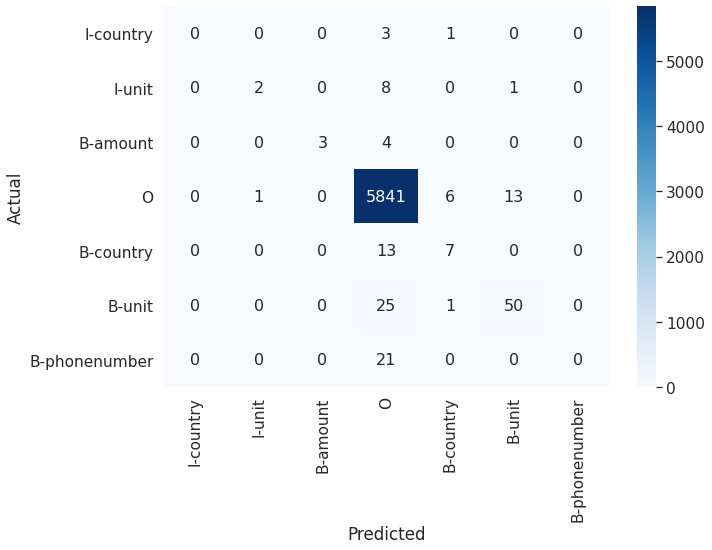

In [ ]:
cm = confusion_matrix(reduce(add,true_labels),reduce(add,true_predictions),labels=unique_tags)
plot_cm(cm,unique_tags);

## Construct Arabert model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(words,final_tags, test_size=0.1,random_state=10)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
model = AutoModelForTokenClassification.from_pretrained("aubmindlab/bert-base-arabertv02",num_labels = 7)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initia

In [ ]:
label_all_tokens = True
max_len=20

In [ ]:
def tokenize_and_align_labels(x_train,y_train):
    tokenized_inputs = tokenizer(list(x_train), truncation=True, is_split_into_words=True,padding='max_length',max_length=max_len)

    labels = []
    for i, label in enumerate(y_train):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(tag2idx[label[word_idx]])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(tag2idx[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_train  = tokenize_and_align_labels(x_train,y_train)
tokenized_val = tokenize_and_align_labels(x_test,y_test)
tokenized_test = tokenize_and_align_labels(test_words,final_test_tags)

In [ ]:
class ArabNERDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}        
        return item

    def __len__(self):
          return len(self.encodings.input_ids)

In [ ]:
train_dataset = ArabNERDataset(tokenized_train)
val_dataset = ArabNERDataset(tokenized_val)
test_dataset = ArabNERDataset(tokenized_test)

In [ ]:
metrics = load_metric('seqeval')

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [unique_tags[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [unique_tags[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metrics.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    report_to="wandb",
    fp16 = True,
    logging_steps = 1
)


trainer = Trainer(
    model=model,                         # the instantiatedTransformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset= val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
Using amp fp16 backend
***** Running training *****
  Num examples = 208
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 21
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.016500,0.044680,0.979167,0.989474,0.984293,0.991031
2,0.009800,0.026247,0.979167,0.989474,0.984293,0.991031
3,0.008200,0.026853,0.978947,0.978947,0.978947,0.986547


***** Running Evaluation *****
  Num examples = 24
  Batch size = 8
***** Running Evaluation *****
  Num examples = 24
  Batch size = 8
***** Running Evaluation *****
  Num examples = 24
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=21, training_loss=0.02643109591943877, metrics={'train_runtime': 19.6572, 'train_samples_per_second': 31.744, 'train_steps_per_second': 1.068, 'total_flos': 6369396359040.0, 'train_loss': 0.02643109591943877, 'epoch': 3.0})

In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=-1)

# Remove ignored index (special tokens)
true_predictions = [
    [unique_tags[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [unique_tags[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metrics.compute(predictions=true_predictions, references=true_labels)

***** Running Prediction *****
  Num examples = 100
  Batch size = 8


In [ ]:
pd.DataFrame(results)

,amount,country,phonenumber,unit,overall_precision,overall_recall,overall_f1,overall_accuracy
precision,1.0,0.785714,1.000000,0.911765,0.936396,0.953237,0.944742,0.974201
recall,1.0,0.916667,0.990826,0.925373,0.936396,0.953237,0.944742,0.974201
f1,1.0,0.846154,0.995392,0.918519,0.936396,0.953237,0.944742,0.974201
number,11.0,24.000000,109.000000,134.000000,0.936396,0.953237,0.944742,0.974201


In [ ]:
report = classification_report(reduce(add,true_labels),reduce(add,true_predictions),labels=unique_tags)

In [ ]:
print(report)

               precision    recall  f1-score   support

    I-country       1.00      0.50      0.67         8
            O       0.98      0.99      0.99       514
     B-amount       1.00      1.00      1.00        11
    B-country       0.92      0.92      0.92        24
       I-unit       0.79      0.79      0.79        14
       B-unit       0.96      0.98      0.97       134
B-phonenumber       1.00      0.99      1.00       109

     accuracy                           0.98       814
    macro avg       0.95      0.88      0.90       814
 weighted avg       0.98      0.98      0.98       814



Classification reports chooses that the AraBERT model that the model predicts all the labels well except for I-Country with correct prediction of only 67%, this could be due to the small number of examples of I-Country in the training set. 

In [ ]:
def plot_cm(data,labels):
  df_cm = pd.DataFrame(data, columns=labels, index = labels)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (10,7))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='0')# font size

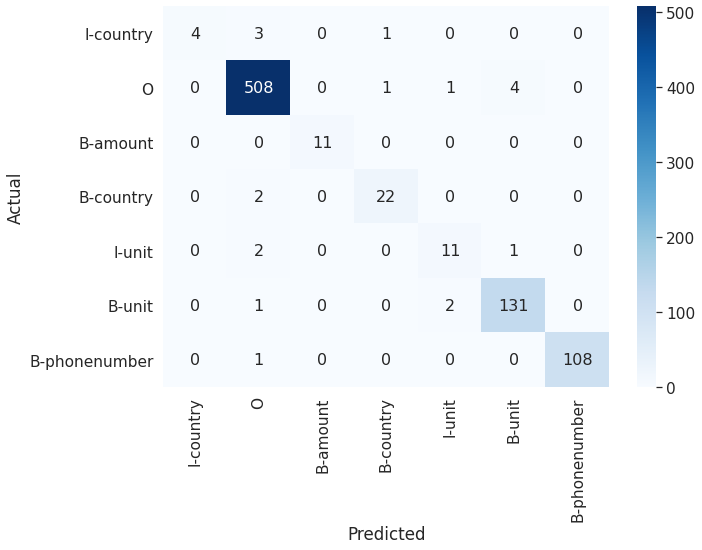

In [ ]:
cm = confusion_matrix(reduce(add,true_labels),reduce(add,true_predictions),labels=unique_tags)
plot_cm(cm,unique_tags);

It is observed from the confusion matrix that the AraBERT model classify 508 to be O, 11 to be B-amount, 22 to be B-country, 131 to be B-unit, 11 to be I-Unit, 4 to be I-Country, and 108 to be B-Phone number correctly. While, in case of O the model miss classifies 1 label as B-Country, 4 labels as B-unit, 1 label as I-unit. In case of B-amount there are no miss classified labels. In case of B-country the model miss classified only 2 labels as O. Moreover, in case of B-unit the model misclassifies 1 label as O, 2 labels as I-unit, while in case of I-unit 1 label is misclassified as B-unit, 2 labels as O. In case of I-Country, 3 labels are misclassified as O, 1 label as B-country. Finally, in B-phonenumber only 1 label is misclassified as O. So, it is observed that I country has the highest miss classified labels with only 4 labels out of 8 to be correctly classified. 

In [ ]:
trainer.save_model('arabertNER')

Saving model checkpoint to arabertNER
Configuration saved in arabertNER/config.json
Model weights saved in arabertNER/pytorch_model.bin


In [ ]:
!cp -r /content/arabertNER /content/drive/MyDrive

## Live Demo

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/arabertNER").to('cuda')

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
unique_tags = ['I-country','O','B-amount','B-country','I-unit','B-unit','B-phonenumber']
tag2idx  =  {t : i for i,t in enumerate(unique_tags)} # Dictionary of every tag and its coressponding id

In [ ]:
def offset_map(p,tokens):
  previous = tag2idx['O']
  offset_mapping = []
  for i,typ in enumerate(p):
    if tokens['offset_mapping'][i][1] == 0 and i!= 0:
        break
    elif typ != tag2idx['O'] and i!= 0:
      index = tokens['offset_mapping'][i]
      if previous == typ:
        prev_start = offset_mapping[-1][0]
        offset_mapping[-1] = (prev_start,index[-1],unique_tags[typ].split('-')[1])
      elif previous != tag2idx['O'] :
        if unique_tags[previous].split('-')[1] == unique_tags[typ].split('-')[1]:
            prev_start = offset_mapping[-1][0]
            offset_mapping[-1] = (prev_start,index[-1],unique_tags[typ].split('-')[1])
        else:
          offset_mapping.append(index)
      else:
        offset_mapping.append(index+ (unique_tags[typ].split('-')[1],))

    previous = typ
  return offset_mapping

In [ ]:
def translate_labels(offset_mapping):
  translator= Translator(from_lang="english",to_lang="arabic")
  example = {'text':'','ents':[],'title':None}
  example['text'] = sentence[0]
  ul = set()
  for ex in offset_mapping:
    ul.add(translator.translate(ex[2]))
    example['ents'].append({'start':ex[0],'end':ex[1],'label':translator.translate(ex[2])})
  return example

In [ ]:
def display_sentence(example):
  colors = {"دولة": "#a7e5dd","الوحدة": '#b9def2',"رقم الهاتف":'#c9cef2',"المبلغ":'#e3b8e6'}
  options = {"ents": ["دولة","الوحدة","رقم الهاتف","المبلغ"], "colors": colors}
  ex = [example]
  display = displacy.render(ex, style="ent", jupyter=True,manual=True,options=options)


In [ ]:
def NER(sentence):
  tokens = tokenizer(list(sentence), truncation=True, is_split_into_words=True,padding='max_length',max_length=60,return_offsets_mapping=True)
  p = model(torch.tensor([tokens['input_ids']]).to('cuda'),attention_mask = torch.tensor([tokens['attention_mask']]).to('cuda'))[0].cpu().detach().numpy()
  p = np.argmax(p,axis=-1)[0]
  offset_mapping = offset_map(p,tokens)
  example = translate_labels(offset_mapping)
  
  return display_sentence(example)

In [ ]:
sentence = [train.text.values[-1]]

In [ ]:
NER(sentence)